# La condition des femmes et le développement économique 
Camille BALLU, Gaëlle DORMION et Julie NOWACK, 2A ENSAE Paris, Janvier 2022

# Introduction 

Selon l'OCDE, l'Organisme de Coopération et de Développement Economique, "Les économies sont plus résilientes, productives et inclusives lorsqu'elles réduisent les inégalités entre les sexes et soutiennent activement la participation égale des femmes dans toutes les sphères de la vie". L'idée selon laquelle les inégalités de genre freinent le développement tant sur un plan économique qu'humain semble mise en avant ici.

C'est ce qui nous a conduites à étudier le lien entre la situation économique et sociale des femmes et le niveau de développement des pays. Nous avons modélisé ce niveau de développment en nous appuyant sur le PIB (Produit Intérieur Brut) par habitant.  

Afin mesurer ce lien, nous avons construit un indicateur multidimensionnel qui évalue l'impact de la condition des femmes sur le développement économique des pays. En nous inspirant des travaux menés sur le GII (Gender Inequality Index), cet indicateur prend en compte de multiples facettes de la situation des femmes en lien avec leur activité et ressources économiques, leur santé, l'autonomie vis-à-vis de leurs corps, leur éducation, leur représentation au niveau politique, ou encore leur famille. Lorsque cela a été possible, nous avons choisi de comparer la situation des femmes à celle des hommes dans un même pays.

Pour mener ce travail, nous nous appuyons principalement sur les données de l'OCDE et de la Banque mondiale ainsi que des données scrappées. 

Avant de débuter, il est nécessaire d'avoir installé sur son environnement Python les packages suivants: 

- geopandas>=0.10 (version)
- numpy
- pycountry
- pandas
- bs4
- folium
- mapclassify

In [1]:
! pip install pycountry
! pip install bs4

In [2]:
import numpy as np
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import pycountry 
import urllib
import bs4
from urllib import request
import statsmodels.api as sm

# 1. Travail préalable de récupération des données

## 1.1. Récupération des données sous le format csv

Les données que nous utilisons proviennent de différentes sources. Nous travaillons principalement sur la base WDIData de la Banque Mondiale, sur la base de 2019 de l'OCDE ainsi que sur des données de l'Union Interparlementaire, mais nous avons dû également scrapper certaines données qui nous paraissaient essentielles à l'étude de la situation des femmes, à l'image du taux de fertilité par femme (présent mais de façon incomplète dans la base de données de la Banque Mondiale) ou encore du droit à l'avortement, sur des sites comme Wikipédia. Nous avons choisi dans l'ensemble de restreindre l'étude à l'année 2019 qui est la dernière année relativement bien documentée avant l'arrivée de la pandémie. 

Nous avons téléchargé nos fichiers .csv sur les sites suivants:
- Données de la Banque mondiale (fichier CSV "WDIData.csv" disponible à [l'adresse suivante]( https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators?fbclid=IwAR2nT7GW8KtjcMaN6VCc3zAuNVPXsGJ8Ew9AvPACwE4703KmMoyiQuRGkc8). Cette base permet de recueillir des données relatives à la situation économique et sociale d'un pays depuis 1960.  
- Données de l'OCDE (fichier CSV "GIDDB2019_05012022164738556.csv" (et renommé "oecd3.csv" dans la suite du projet) disponible à [l'adresse suivante](https://stats.oecd.org/viewhtml.aspx?datasetcode=GIDDB2019&lang=fr). Des données relatives à l'égalité homme-femme y sont disponibles pour l'année 2019. 

- Données de l'Union Interparlementaire, disponibles aux adresses suivantes (3 Data set) :  [pour le pourcentage de femmes au sein des parlements](https://data.ipu.org/fr/women-ranking?month=11&year=2021),[pour l'existence d'un organe spécialisé sur la question de l'égalité des sexes](https://data.ipu.org/fr/specialized-bodies/fr?sb_theme=106)  et pour [les données sur l'existence de quotas électoraux au parlement des différents pays](https://data.ipu.org/fr/compare?field=chamber%3A%3Afield_is_electoral_quota_women&structure=any__lower_chamber#map). 

## 1.2. Scrapping des données

### 1.2.1. Scrapping du taux de fertilité 

On scrappe des données relatives à la législation sur l'avortement sur le site Wikipédia ("https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependencies_by_total_fertility_rate").

In [3]:
#Scrapping
url_fertility_tx = "https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependencies_by_total_fertility_rate"
request_text = request.urlopen(url_fertility_tx).read() 
page = bs4.BeautifulSoup(request_text, "lxml")
table_fertility_tx = page.find('table', {'class' : 'wikitable sortable'})
table_body = table_fertility_tx.find('tbody')

rows = table_body.find_all('tr')
cols = rows[1].find_all('td')

dico_fertility = dict()
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0 : 
        dico_fertility[cols[1]] = cols[2:]

In [4]:
#On organise les données dans un dataframe
data_fertility = pandas.DataFrame.from_dict(dico_fertility,orient='index')

Il s'agit désormais de nettoyer les données scrappées et de les mettre en forme pour pouvoir les exploiter après. 

In [5]:
#On réorganise les colonnes du dataframe
for row in rows:
    cols = row.find_all('th')
    if len(cols) > 0 : 
        cols = [ele.get_text(separator=' ').strip().title() for ele in cols]
        columns_pays = cols

In [6]:
# Mise en forme du dataframe pour le rendre plus lisible
data_fertility.columns = columns_pays[2:]
data_fertility.reset_index(inplace=True)
data_fertility.rename(columns={'index': 'Country Name'}, inplace=True)
data_fertility.rename(columns={'Fertility Rate   In 2019 (Births/Woman)': 'Fertility'}, inplace=True)

A l'aide du package pycountry de python, on peut ajouter au dataframe une colonne indiquant le code du pays, présent dans la base de données de la Banque Mondiale et dans la base de données de l'OCDE  et que nous allons utiliser par la suite pour la création des indicateurs car les noms des pays des deux bases sont donnés respectivement en anglais et en français. 
Le code alpha 3 servira de clé de jointure pour fusionner nos différents Data Frame. 

In [7]:
def code_pays(column):
    """
    Permet d'ajouter une colonne comportant le code alpha 3 associé à chaque nom de pays
    column : nom de la colonne
    """
    
    CODE=[]
    
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3  # .alpha_3 est utilisé pour donner le code en 3 lettres du pays
            CODE.append(code)
        except:
            CODE.append('None')
            
    return CODE # Retourne une colonne comportant les codes alpha 3 

In [8]:
# On applique notre fonction code_pays à notre data frame pour récupérer le code alpha 3
data_fertility['CODE']=code_pays(data_fertility["Country Name"])

# On renomme la colonne
data_fertility.rename(columns={'CODE': 'Country Code'}, inplace=True)

Certaines données du tableau ne sont pas exploitbales et doivent par conséquent être nettoyées, soit parce qu'il n'y a pas de taux de fertilité donné pour ces pays (ex:(-)), soit parce qu'elles relèvent de données d'années antérieures à 2019. Nous faisons le choix pour ces pays de remplacer le taux de fertilité de 2019 par ces données antérieures, afin d'avoir une base aussi complète que possible, en faisant l'hypothèse que le taux de fertilité pour ces pays a probablement peu changé en l'espace de quelques années. 

In [9]:
data_fertility2=data_fertility

In [10]:
def cleaner_fertility(char: str ):
    """
    Permet de nettoyer les données 
    """
    
    try:
        # On remplace les '-' par des NaN
        if '-' in char : return np.NaN
        
        # On supprime les éventuelles informations entre parenthèses
        elif '(' in char :
            i=0
            while char[i+1]!='(':
                i+=1
            return float(char[:i])
        
        else: return float(char)
    
    except:
        
        return char # On retourne la chaîne de caractères ainsi nettoyée

In [11]:
data_fertility2.dropna(inplace=True) # fonction qui enlève les potentiels "NaN" présents
data_fertility2["Fertility"] = data_fertility2["Fertility"].apply(cleaner_fertility) # On nettoie les données de la variable "Fertility"

In [12]:
# On ne conserve que les colonnes nécessaires à la création de notre base de données globale
data_fertility2.drop(data_fertility2.columns[[0]], axis=1, inplace = True)

In [13]:
# On supprime les lignes où le code pays ne serait pas renseigné 
supprimer=["None"] # Valeur de 'Country Code' pour les lignes qui doivent être supprimées
data_fertility2=data_fertility2[~data_fertility2['Country Code'].isin(supprimer)] # On ne conserve que les lignes où 'Country Code' est différent de 'None'
data_fertility2["Fertility"] = data_fertility2["Fertility"].astype(float, errors = 'raise') # On change le type de la variable de string à float
data_fertility2

C:\Users\Ca1000\AppData\Local\Temp/ipykernel_7932/1731069103.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fertility2["Fertility"] = data_fertility2["Fertility"].astype(float, errors = 'raise') # On change le type de la variable de string à float


,Fertility,Country Code
0,6.824,NER
1,5.978,SOM
3,5.785,MLI
4,5.649,TCD
5,5.442,AGO
...,...,...
257,1.300,SMR
259,2.100,KNA
260,NaN,TCA
261,NaN,TUV


In [14]:
# Exportation sous fichier .csv 
data_fertility2.to_csv('data_fertility2.csv')

### 1.2.2. Scrapping de la législation sur l'avortement 

On scrappe des données relatives à la législation sur l'avortement sur le site Wikipédia ("https://en.wikipedia.org/wiki/Abortion_law").

In [15]:
url_abortion_law = "https://en.wikipedia.org/wiki/Abortion_law"
request_text = request.urlopen(url_abortion_law).read() 
page = bs4.BeautifulSoup(request_text, "lxml")
table_abortion_law = page.find('table', {'class' : 'wikitable sortable collapsible'})
table_body = table_abortion_law.find('tbody')

rows = table_body.find_all('tr')
cols = rows[1].find_all('td')

dico_abortion = dict()
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0 : 
        dico_abortion[cols[0]] = cols[1:]

In [16]:
data_abortion = pandas.DataFrame.from_dict(dico_abortion,orient='index')

On nettoie ensuite le dataframe. Pour cela, on choisit de créer une indicatrice traduisant la possibilité pour les femmes d'avorter ou non par choix. Il convient donc de recoder la variable 'On Request', qui prend des valeurs multiples, en une variable binaire (1: possibilité d'avorter par choix, 0: impossibilité). 

In [17]:
def cleaner_abortion (char: str):
    """
    Permet de nettoyer les données
    """
    
    assert type(char)==str, "The row does not contains str"
    
    # On remplace les '-' par des NaN
    if '-' in char: return np.NaN 
    
    # On supprime les éventuelles informations entre crochets
    elif '[' in char:
        i=0
        while char[i+1]!= '[':
            i+=1
        
        # On retourne la nouvelle chaîne de caractères
        return str(char[:i+1])
    
    else: return str(char) 

In [18]:
for row in rows:
    cols = row.find_all('th')
    if len(cols) > 0 : 
        cols = [ele.get_text(separator=' ').strip().title() for ele in cols]
        columns_country = cols

In [19]:
# Mise en forme du Data Frame pour le rendre plus lisible
data_abortion.columns = columns_country[1:]
data_abortion.reset_index(inplace=True)
data_abortion.rename(columns={'index': 'Country Name'}, inplace=True)
data_abortion.head()

,Country Name,Risk To Life,Risk To Health,Rape,Fetal Impairment,Economic Or Social,On Request
0,Abkhazia[32],prohibited,prohibited,prohibited,prohibited,prohibited,prohibited
1,Afghanistan[needs update?],permitted[k],prohibited,prohibited,prohibited[k],prohibited[k],prohibited
2,Albania[16],22 weeks,22 weeks,22 weeks,no limit,22 weeks,12 weeks
3,Algeria[39],permitted,permitted,prohibited,prohibited,prohibited,prohibited
4,Andorra,prohibited[l],prohibited,prohibited,prohibited,prohibited,prohibited


In [20]:
# On recode la variable en une variable binaire
# Tous les valeurs comportant les termes "permitted" ou "weeks" sont recodées pour prendre la valeur 1. Les autres prennent 0.
data_abortion2=data_abortion
data_abortion2['abortion'] = data_abortion2['On Request'].str.contains("permitted|weeks", na=False).astype(int) 

# On nettoie le Data Frame à l'aide de la fonction cleaner_abortion
data_abortion2["Country Name"]=data_abortion2["Country Name"].apply(cleaner_abortion)

# On conserve uniquement les colonnes utiles
data_abortion2=data_abortion2[["Country Name", "abortion"]]
data_abortion2.head(5)

,Country Name,abortion
0,Abkhazia,0
1,Afghanistan,0
2,Albania,1
3,Algeria,0
4,Andorra,0


In [21]:
# Exportation sous fichier .csv 
data_abortion2.to_csv('data_abortion2.csv')

## 1.3. Nettoyage des bases de données de la Banque mondiale et de l'OCDE

### 1.3.1. Df de la Banque mondiale

In [22]:
# Dataframe de la Banque mondiale 
df_bm=pd.read_csv("WDIData.csv")
df_bm.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,16.320475,16.643243,16.994695,17.313168,17.604950,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,32.224027,32.046478,31.323579,33.312163,38.380433,39.754201,42.168241,43.640661,NaN,NaN
2,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,20.525353,19.461383,17.790698,16.553470,23.907897,24.624725,26.813900,28.841150,NaN,NaN


In [23]:
# On se restreint aux observations de 2019
df_bm2=df_bm[["Country Code", "Country Name", "Indicator Name", "Indicator Code", "2019"]]
df_bm2.head(5)

,Country Code,Country Name,Indicator Name,Indicator Code,2019
0,AFE,Africa Eastern and Southern,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN
1,AFE,Africa Eastern and Southern,Access to electricity (% of population),EG.ELC.ACCS.ZS,43.640661
2,AFE,Africa Eastern and Southern,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,28.841150
3,AFE,Africa Eastern and Southern,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,73.589886
4,AFE,Africa Eastern and Southern,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,NaN


### 1.3.2. Df de l'OCDE

In [24]:
df_ocde=pd.read_csv('./oecd3.csv', sep=',', encoding='latin-1')
df_ocde.head(5)

,"ï»¿""REGION""",RÃ©gion,LOCATION,Pays,INC,Revenu,VAR,Variable,TIME,AnnÃ©e,Value,Flag Codes,Flags
0,ASI,Asie,AUS,Australie,HIN,ÃlevÃ©,DF_HR_LAW,Loi,2019,2019,0.50,NaN,NaN
1,ASI,Asie,AUS,Australie,HIN,ÃlevÃ©,DF_HR_ATT,Attitudes,2019,2019,21.10,NaN,NaN
2,ASI,Asie,AUS,Australie,HIN,ÃlevÃ©,DF_HR_PRACT,Pratique,2019,2019,1.82,NaN,NaN
3,ASI,Asie,AUS,Australie,HIN,ÃlevÃ©,DF_DV_LAW,Loi,2019,2019,0.00,NaN,NaN
4,ASI,Asie,AUS,Australie,HIN,ÃlevÃ©,DF_IN_LAW,Loi,2019,2019,0.00,NaN,NaN


In [25]:
# On ne sélectionne que les lignes 'pratique' qui correspondent à la réalité des faits 
df_ocde2=df_ocde[df_ocde['Variable']=="Pratique"]

# On renomme les variables
df_ocde2.rename(columns={'ï»¿"REGION"': 'region_monde', 'RÃ©gion': 'region', 'LOCATION': 'Country Code', 'Pays':'Country Name'}, inplace=True)

df_ocde2=df_ocde2[df_ocde2['region_monde']=="ALL"]
df_ocde3=df_ocde2[['Country Code', 'Country Name', 'VAR', 'Value']]
df_ocde3.head(5)

C:\Users\Ca1000\anaconda3\envs\projetPython2A\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Country Code,Country Name,VAR,Value
29,AUS,Australie,DF_HR_PRACT,1.82
34,AUS,Australie,RPI_VAW_PRACT,16.90
36,AUS,Australie,RPI_MW_PRACT,105.50
38,AUS,Australie,RPI_RA_PRACT,11.00
42,AUS,Australie,RAPFR_SAFS_PRACT,50.00


### 1.3.3 Df de l'Union Parlementaire

Les données de l'Union Parlementaire que nous avons récupérées sont dispersées dans 3 fichiers .csv différents. Il s'agit donc de les regrouper et de les nettoyer de telle sorte à pouvoir les fusionner aux restes des bases de données dont nous disposons.

In [26]:
# On importe les bases de données nécessaires 
df_percent_women = pd.read_csv('./chamber--current_women_percent.csv', sep=',', encoding='utf-8')
df_quota = pd.read_csv('./chamber--field_is_electoral_quota_women.csv', sep=',', encoding='utf-8')
df_spe_body = pd.read_csv('./chamber--specialized_body__women.csv', sep=',', encoding='utf-8')

In [27]:
# On rend le Data Frame plus lisible
df_percent_women = df_percent_women.iloc[3: , : ]
df_percent_women.drop(df_percent_women.columns[[0]], axis=1, inplace=True)

In [28]:
# On change le nom des différentes colonnes
df_percent_women.columns = ["Country", "Elections (lower house)", "Seats", "Women", "Women proportion (lower house)", "Elections (upper house)", "Seats", "Women", "Women proportion (upper house)"]
df_percent_women = df_percent_women.iloc[2: , : ]

# On réinitiliase l'index après avoir supprimé les lignes superflues 
df_percent_women.reset_index(inplace=True, drop=True)

In [29]:
# On ne conserve que les colonnes utiles
df_percent_women2 = df_percent_women[["Country", "Women proportion (upper house)"]]

In [30]:
def cleaner_parliament(df, d, l):
    """
    Permet de nettoyer les données
    df est le data frame
    d représente l'indice des colonnes à supprimer
    l représente l'indice de lignes à partir duquel il convient de conserver les données
    """
    
    # On supprime les colonnes vides
    df = df.drop(df.columns[d], axis=1) 
    
    # On conserve les lignes comportant les noms des colonnes et les données
    df = df.iloc[l: , : ] 
    
    # On renomme les colonnes avec les valeurs de la première ligne
    df.columns = df.iloc[0] 
    
    # On réinitialise l'index
    df.reset_index(inplace=True, drop=True) 
    df = df.iloc[pd.RangeIndex(len(df)).drop(0)] 
    df.reset_index(inplace=True, drop=True)
    
    return df # Retourne le Data frame nettoyé

In [31]:
# On applique la fonction  cleaner_parliament aux données sur les quotas et on renomme les colonnes
df_quota =  cleaner_parliament(df_quota, 6, 5)
df_quota.columns = ["2-alpha code", "Country", "House", "Quota", "Structure", "House type"]

In [32]:
#On ne conserve que les colonnes utiles
df_quota = df_quota[["2-alpha code", "Country", "Quota"]]

In [33]:
# On applique la fonction  cleaner_parliament aux données sur l'existence d'un organe spécialisé et on renomme les colonnes
df_spe_body =  cleaner_parliament(df_spe_body, 6, 5)
df_spe_body.columns = ["2-alpha code", "Country", "House", "Specialized body", "Structure", "House type"]

In [34]:
#On ne conserve que les colonnes utiles
df_spe_body2 = df_spe_body[["2-alpha code", "Specialized body"]]

Pour pouvoir fusionner cette base de données aux autres, il nous faut le code alpha 3 de chaque pays. Nous n'avons ici que le code alpha 2. Nous utilisons donc à nouveau le module pycountry pour récupérer le code alpha 3. 

In [35]:
def code_pays_3(column):
    """
    Permet d'ajouter une colonne comportant le code alpha 3 associé à au code alpha 2 de chaque pays
    column : nom de la colonne
    """
        
    CODE=[]
    for code in column:
        
        try:
            code=pycountry.countries.get(alpha_2=code).alpha_3 # .alpha_3 est utilisé pour donner le code en 3 lettres du pays
            CODE.append(code)
            
        except:
            CODE.append('None')
            
    return CODE # Retourne une colonne comportant les codes alpha 3

In [36]:
# On applique la fonction à notre Data Frame et on renomme la colonne
df_spe_body2['CODE']=code_pays_3(df_spe_body2["2-alpha code"])
df_spe_body2.rename(columns={'CODE': 'Country Code'}, inplace=True)

C:\Users\Ca1000\AppData\Local\Temp/ipykernel_7932/47368720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spe_body2['CODE']=code_pays_3(df_spe_body2["2-alpha code"])
C:\Users\Ca1000\anaconda3\envs\projetPython2A\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [37]:
#On fusionne ces bases de données
df_rp = df_quota.merge(df_spe_body2, on='2-alpha code', how='left')
df_rp = df_rp.merge(df_percent_women2, on='Country', how='left')
df_rp = df_rp.drop(df_rp.columns[0], axis=1)
df_rp = df_rp.drop(df_rp.columns[0], axis=1)
df_rp

,Quota,Specialized body,Country Code,Women proportion (upper house)
0,Oui,Oui,AFG,27.9
1,Oui,Oui,ZAF,41.5
2,Oui,Oui,ALB,-
3,Oui,Non,DZA,5.7
4,Oui,Oui,DEU,33.3
...,...,...,...,...
185,Oui,Pas d'information,VEN,-
186,Non,Oui,VNM,-
187,Non,Pas d'information,YEM,1.1
188,Non,Oui,ZMB,-


Les variables "Specialized body" et "Quota" sont des variables qualitatives qui ne sont pas directement utilisables pour la construction de notre indicateur. Comme précédemment, nous allons recoder ces variables pour les rendres binaires. 

In [38]:
def replace_column(df, col_name, L_old_value, L_new_value) :
    """
    Permet de recoder une variable valeur par valeur
    df est le data frame à modifier
    col_name est le nom de la colonne
    L_old_value est la liste de valeurs à transformer 
    L_new_value est la liste des nouvelles valeurs à remplacer
    """
    
    # On parcout la liste des anciennes valeurs
    for i in range(len(L_old_value)) : 
        
         # On remplace l'ancienne valeur par la nouvelle
        df[col_name] = df[col_name].replace(L_old_value[i], L_new_value[i])
        
    return df # Retourne le data frame modifié

In [39]:
# On applique la fonction à nos différents Data frame pour les recoder 
replace_column(df_rp, "Quota", ['Oui', 'Non', "Pas d'information"], [1, 0, np.nan])
replace_column(df_rp, "Specialized body", ['Oui', 'Non', "Pas d'information"], [1, 0, np.nan])
replace_column(df_rp, "Women proportion (upper house)", ['-'], [np.nan])

,Quota,Specialized body,Country Code,Women proportion (upper house)
0,1,1.0,AFG,27.9
1,1,1.0,ZAF,41.5
2,1,1.0,ALB,NaN
3,1,0.0,DZA,5.7
4,1,1.0,DEU,33.3
...,...,...,...,...
185,1,NaN,VEN,NaN
186,0,1.0,VNM,NaN
187,0,NaN,YEM,1.1
188,0,1.0,ZMB,NaN


In [40]:
# On change le type de notre variable de string à float
df_rp["Women proportion (upper house)"] = df_rp["Women proportion (upper house)"].astype(float, errors = 'raise')

# 2.Sélection des indicateurs pertinents

Le premier indicateur que nous avons particulièrement exploité dans le cadre de ce projet est l'indicateur PIB par habitant de 2019 de la Banque Mondiale ("GDP per capita 2019"). Nous avons estimé que cet indicateur serait le plus pertinent et le plus facilement exploitable pour mesurer le niveau de développement économique du pays dans le cadre de notre étude, bien qu'il soit contesté et contestable.

## 2.1. Quelques fonctions utiles 

In [41]:
def bm_select(Indicator, row_name):
    """
    Permet de sélectionner les variables pertinentes pour notre étude dans le data frame de la Banque Mondiale
    Indicator est la variable que l'on souhaite récupérer
    row_name est le nom que l'on souhaite donner à la colonne
    """

    # On crée un indicateur avec uniquement la variable qui nous intéresse
    df=df_bm2[df_bm2['Indicator Code']==Indicator]
    
    # On conserve l'année 2019
    df=df[["Country Code", "2019"]]
    
    # On renomme la colonne
    df.rename(columns={'2019':row_name}, inplace=True)
    
    return df # Retourne le nouveau data frame

def ocde_select(Indicator, row_name):
    """
    Permet de sélectionner les variables pertinentes pour notre étude dans le data frame de l'OCDE
    Indicator est la variable que l'on souhaite récupérer
    row_name est le nom que l'on souhaite donner à la colonne    
    """

    df=df_ocde3[df_ocde3['VAR']==Indicator]
    df=df[["Country Code", "Value"]]
    df.rename(columns={'Value':row_name}, inplace=True)
    
    return df

## 2.2. Le PIB par habitant, 2019 

In [42]:
# On applique la fonction précédente pour sélectionner les données du PIB 
df_pib=bm_select('NY.GDP.PCAP.KD', "GDP per capita 2019")

# On rend les données plus lisibles en sélectionnant également le nom du pays
df_pib_name=df_bm2[df_bm2['Indicator Name']=="GDP per capita (constant 2015 US$)"]
df_pib_name=df_pib_name[["Country Name","2019", "Country Code"]]
df_pib_name.rename(columns={'2019': 'GDP per capita 2019'}, inplace=True)

On effectue quelques statistiques descriptives de ce PIB en le visualisant par continent. Pour cela, on se sert du fichier "world.csv", importé depuis geopandas, qui associe un continent à chaque code pays.

Text(0.5, 0, 'GDP per capita (2019)')

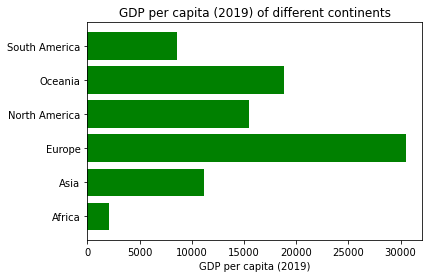

In [43]:
# Importation du dataframe
# df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world=pd.read_csv("World.csv")

# On harmonise le data frame 
df_world.rename(columns={'iso_a3': 'Country Code'}, inplace=True)
df_world=df_world[["continent", "Country Code"]]

# On fusionne cette base avec celle du PIB
dfpib_continent=df_world.merge(df_pib_name, on='Country Code', how='right')

# On calcule le PIB moyen par continent
dfpib_continent=dfpib_continent.groupby('continent').mean()
dfpib_continent=dfpib_continent.reset_index()

# Réalisation du diagramme en barres
plt.barh(dfpib_continent["continent"], dfpib_continent['GDP per capita 2019'], color="green")
plt.title('GDP per capita (2019) of different continents')
plt.xlabel('GDP per capita (2019)')

On remarque que les continents ont des PIB par tête très différents. Si en moyenne le PIB par tête européen atteint les 30000 dollars, ce dernier atteint environ 2000 dollars en Afrique. 

## 2.3. Données relatives à la condition des femmes 

Au sein des bases de données de la Banque Mondiale et de l'OCDE, nous avons effectué un gros travail afin de trouver les indicateurs complets et pertinents dans notre cadre d'étude, à savoir celui de l'impact de la condition des femmes sur le niveau de développement économique des pays. Par exemple, nous avons été amenées dans un premier temps à créer des sous-dataframes du dataframe de la Banque Mondiale regroupant les indicateurs contenant les termes "gender", "female" ou encore "women", puis à les examiner pour un seul pays à l'image de la France afin d'en avoir une meilleure visibilité (dans la mesure où l'indicateur existe pour chaque pays). 

In [44]:
# On cherche les indicateurs contenant des termes liés aux inégalité entre hommes et femmes et on les regroupe dans des sous-dataframes
df_bm2.rename(columns={'Indicator Name': 'Indicator'}, inplace=True)
df_women=df_bm2[df_bm2.Indicator.str.contains('women', case=False)]
df_gender=df_bm2[df_bm2.Indicator.str.contains('gender', case=False)]
df_female=df_bm2[df_bm2.Indicator.str.contains('female', case=False)]

C:\Users\Ca1000\anaconda3\envs\projetPython2A\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Par exemple:

In [45]:
# On affiche les 5 premières variables du dataframe comportant les indicateurs français où l'on retrouve le terme 'women'
FR=df_women[df_women['Country Name']=="France"]
FR.head()

,Country Code,Country Name,Indicator,Indicator Code,2019
168879,FRA,France,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,4.7454
168918,FRA,France,Antiretroviral therapy coverage for PMTCT (% o...,SH.HIV.PMTC.ZS,NaN
169060,FRA,France,"Contraceptive prevalence, any methods (% of wo...",SP.DYN.CONU.ZS,NaN
169061,FRA,France,"Contraceptive prevalence, modern methods (% of...",SP.DYN.CONM.ZS,NaN
169128,FRA,France,Demand for family planning satisfied by modern...,SH.FPL.SATM.ZS,NaN


Puis nous avons étudié manuellement les indicateurs de ce dataframe et leurs corrélations avec par exemple le PIB par habitant en 2019. Voici quelques exemples de variables qui nous ont semblées plus pertinentes que d'autres.

In [46]:
def corr_indicateurs(df1, df2, indicator_name) :
    """
    Permet de réaliser un graphique représentant les données du PIB par pays en fonction d'un indicateur choisi
    df1 est le dataframe comportant les données explicatives
    df2 est le data frame comportant les données que l'on cherche à expliquer
    indicator_name est la variable explicative
    """
    
    # On sélectionne l'indicateur qui nous intéresse
    X = df1[df1['Indicator']== indicator_name] 
        
    # On supprime la colonne 'Indicator code'
    X = X.drop(['Indicator Code'], axis = 1)
    
    # On supprime la colonne country name de la base PIB
    Y = df2.drop(['Country Name'], axis = 1)
    
    # On fusionne les 2 bases de données
    Z = X.merge(Y, how='inner', on= 'Country Code')
    
    # On supprime les lignes où certaines données sont manquantes
    index_with_nan = Z.index[Z.isnull().any(axis=1)]
    Z.drop(index_with_nan,0, inplace=True)
    
    # On affiche le nombre d'observations restantes
    print("Le nombre d'obervations est : ", Z.shape[0]) 
    
    # On réalise les graphiques de corrélation
    X_ = Z.iloc[:,3].values
    y_ = Z.iloc[:,4].values
    
    graph = plt.scatter(X_, y_, color="green")
    
    return graph # Retourne le graphique 

Le nombre d'obervations est :  127


C:\Users\Ca1000\AppData\Local\Temp/ipykernel_7932/3270361332.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Z.drop(index_with_nan,0, inplace=True)


Text(0, 0.5, 'GDP per capita (2019) ($)')

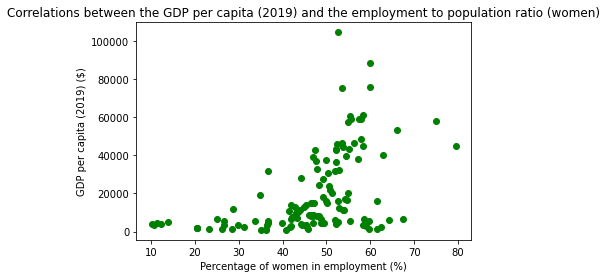

In [47]:
#Graphique de corrélation pour l'indicateur 'Employment to population ratio, 15+, female (%) (national estimate)'

corr_indicateurs(df_female, df_pib_name, 'Employment to population ratio, 15+, female (%) (national estimate)')
plt.title('Correlations between the GDP per capita (2019) and the employment to population ratio (women)')
plt.xlabel('Percentage of women in employment (%)')
plt.ylabel('GDP per capita (2019) ($)')

Le nombre d'obervations est :  231


C:\Users\Ca1000\AppData\Local\Temp/ipykernel_7932/3270361332.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Z.drop(index_with_nan,0, inplace=True)


Text(0, 0.5, 'GDP per capita (2019) ($)')

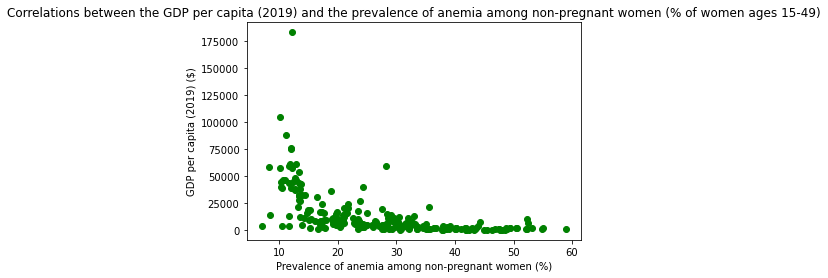

In [48]:
#Graphique de corrélation pour l'indicateur 'Prevalence of anemia among non-pregnant women (% of women ages 15-49)'

corr_indicateurs(df_women, df_pib_name, 'Prevalence of anemia among non-pregnant women (% of women ages 15-49)')
plt.title('Correlations between the GDP per capita (2019) and the prevalence of anemia among non-pregnant women (% of women ages 15-49)')
plt.xlabel('Prevalence of anemia among non-pregnant women (%)')
plt.ylabel('GDP per capita (2019) ($)')

Le nombre d'obervations est :  225


C:\Users\Ca1000\AppData\Local\Temp/ipykernel_7932/3270361332.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Z.drop(index_with_nan,0, inplace=True)


Text(0, 0.5, 'GDP per capita (2019) ($)')

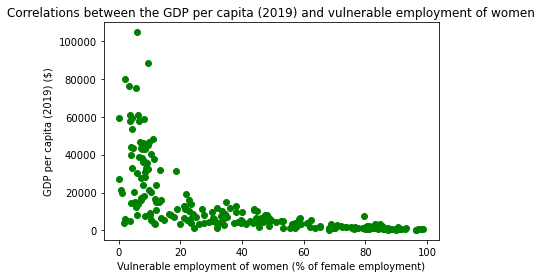

In [49]:
#Graphique de corrélation pour l'indicateur 'Vulnerable employment, female (% of male employment) (modeled ILO estimate)'

corr_indicateurs(df_female, df_pib_name, 'Vulnerable employment, female (% of female employment) (modeled ILO estimate)')
plt.title('Correlations between the GDP per capita (2019) and vulnerable employment of women')
plt.xlabel('Vulnerable employment of women (% of female employment)')
plt.ylabel('GDP per capita (2019) ($)')

Pour les 3 variables choisies en exemple ci-dessus, il semble possible d'établir un lien entre elles et la valeur du PIB par pays. En effet, le nuage de points sur chacun des graphiques suit une tendace très nette qui laisse penser que la variable explicative peut être pertinente. Ce n'est pas le cas de toutes les variables: 

Le nombre d'obervations est :  40


C:\Users\Ca1000\AppData\Local\Temp/ipykernel_7932/3270361332.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Z.drop(index_with_nan,0, inplace=True)


Text(0, 0.5, 'GDP per capita (2019)($)')

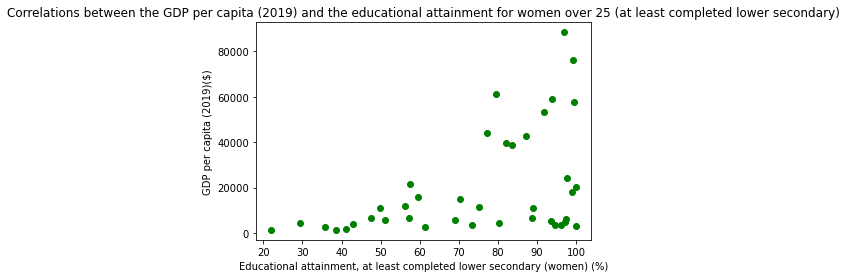

In [50]:
#Exemple d'indicateur non pertinent : Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)

corr_indicateurs(df_female, df_pib_name, 'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)')
plt.title('Correlations between the GDP per capita (2019) and the educational attainment for women over 25 (at least completed lower secondary)')
plt.xlabel('Educational attainment, at least completed lower secondary (women) (%)')
plt.ylabel('GDP per capita (2019)($)')

Cette variable est renseignée pour trop peu de pays pour pouvoir être intégrée au modèle.

Nous avons choisi de ne pas intégrer les variables peu renseignées à notre projet, même si celles-ci pouvaient nous paraître pertinente, dans la mesure où cela aurait nui à la validité de notre modèle. 
Nous avons choisi de retenir au total 17 variables explicatives dans notre base de donnée du projet : 
- Fertility
- Life expectancy of women at birth
- Prevalence of anemia among non pregnant women
- Women share of population living with HIV 
- Domestic time ratio women on men
- Women s share amoung bank account owners 
- Adolescents out of school, female
- Children out of school, female
- Primary completion rate, female
- No contraception used without wanting having children
- Physical and sexual violences on women
- Abortion
- Women on vulnerable job
- Employment to population ratio, 15+, female
- Quota in parliament
- Specialized body (regarding gender equality) in parliament
- Women proportion (upper house)

A cette liste s'ajoute dans certains cas l'équivalent de ces variables pour les hommes, à titre de comparaison.
Cette liste n'est bien entendu pas exhaustive et représente ce que nous sommes parvenues à obtenir de plus pertinent et de plus complet concernant la situation des femmes. Les inégalités que subissent les femmes sont multidimensionnelles et nous avons essayé de retenir autant que possible des variables représentatives de ces différentes dimensions des inégalités hommes/femmes. 

# 3. Création de la base de données

## 3.1. Création de la base de données des variables explicatives principales

In [51]:
# On récupère toutes les données de nos variables explicatives à l'aide des fonctions définies précédemment 

df_esperance_de_vie=bm_select("SP.DYN.LE00.FE.IN", 'Life expectancy of women at birth' )
df_anemia=bm_select("SH.ANM.NPRG.ZS", 'Prevalence of anemia among non pregnant women' )
df_hiv=bm_select("SH.DYN.AIDS.FE.ZS", 'Women share of population living with HIV' )
df_domestique=ocde_select("DF_HR_PRACT",'Domestic time ratio women on men')
df_banque=ocde_select("RAPFR_SAFS_PRACT",'Women s share amoung bank account owners')
df_descolariation_ado_w=bm_select("SE.PRM.UNER.FE.ZS",'Adolescents s share out of school, female')
df_descolariation_child_w=bm_select("SE.SEC.UNER.LO.FE.ZS",'Children s share out of school, female')
df_primary_completion_rate_f=bm_select("SE.PRM.CMPT.FE.ZS",'Women who completed primary')
df_descolariation_ado_m=bm_select("SE.SEC.UNER.LO.MA.ZS",'Adolescents s share out of school, male')
df_descolariation_child_m=bm_select("SE.PRM.UNER.MA.ZS",'Children s share out of school, male')
df_primary_completion_rate_m=bm_select("SE.PRM.CMPT.MA.ZS",'Men who completed primary')
df_contraception = ocde_select("RPI_RA_PRACT", 'No contraception used without wanting having children')
df_violences = ocde_select("RPI_VAW_PRACT", 'Physical and sexual violences on women')
df_employment= bm_select("SL.EMP.TOTL.SP.FE.NE.ZS",'Employment to population ratio, 15+, female')
df_vulnerableF=bm_select("SL.EMP.VULN.FE.ZS",'Vulnerable job, female')
df_vulnerableM=bm_select("SL.EMP.VULN.MA.ZS",'Vulnerable job, male')

Le dataframe sur l'avortement, ayant été scrappé, a été plus difficile à harmoniser pour permettre la fusion. Seul le nom du pays y figure. Afin de récupérer une clé de jointure (le code pays) commune à toutes les variables, nous le fusionnons avec le dataframe df_pib_name, qui a l'avantage de contenir à la fois un code pays et le nom du pays. 

In [52]:
# Fusion avec df_pib_name pour récupérer la clé de jointure
df_avortement=data_abortion2.merge(df_pib_name, on='Country Name', how='inner')
df_avortement=df_avortement[["Country Name","Country Code", "GDP per capita 2019", "abortion"]]

In [53]:
# On ne conserve que les colonnes utiles
df_avortement = df_avortement[['Country Code', 'abortion']]

In [54]:
# On fusionne l'ensemble de nos dataframe à partir de la clé de jointure "Country Code"
df = df_esperance_de_vie.merge(df_domestique, on='Country Code', how='left')
df = df.merge(df_hiv, on='Country Code', how='outer')
df = df.merge(df_anemia, on='Country Code', how='outer')
df = df.merge(df_banque, on='Country Code', how='outer')
df = df.merge(df_descolariation_ado_w, on='Country Code', how='outer')
df = df.merge(df_descolariation_child_w, on='Country Code', how='outer')
df = df.merge(df_primary_completion_rate_f, on='Country Code', how='outer')
df = df.merge(df_descolariation_ado_m, on='Country Code', how='outer')
df = df.merge(df_descolariation_child_m, on='Country Code', how='outer')
df = df.merge(df_primary_completion_rate_m, on='Country Code', how='outer')
df = df.merge(df_contraception, on='Country Code', how='outer')
df = df.merge(df_violences, on='Country Code', how='outer')
df = df.merge(df_employment, on='Country Code', how='outer')
df = df.merge(df_vulnerableF, on='Country Code', how='outer')
df = df.merge(df_vulnerableM, on='Country Code', how='outer')
df = df.merge(df_avortement, on='Country Code', how='left')
df = df.merge(df_rp, on='Country Code', how='outer')
df = df.merge(data_fertility2, on='Country Code', how='left')

# On supprime les doublons
df= df.drop_duplicates()

In [55]:
# On supprime les lignes sans code pays
supprimer=["None"]
df=df[~df['Country Code'].isin(supprimer)]

In [56]:
#On réinitialise l'index
df = df.reset_index(drop=True)

## 3.2. Création des variables calculées 

D'une part, nous souhaitons examiner spécifiquement ce qui fait la particularité de la situation des femmes, et cela nécessite pour un certain nombre de variables d'effectuer un ratio de l'indicateur relatif à la population des femmes sur celui relatif à la population des hommes. 

Nous souhaitons également faire en sorte que toutes nos variables varient dans le même sens à savoir que plus la variable est élevée, meilleure est la situation des femmes. Nous avons par conséquent effectué des manipulations sur certains des indicateurs pour répondre à ces besoins. 

In [57]:
df["Share of np women living without anemia"]=100-df["Prevalence of anemia among non pregnant women"]
df["Share of np women living without HIV"]=100-df["Women share of population living with HIV"]
df["Domestic time ratio women on men (quota)"]=100-df["Domestic time ratio women on men"]
df["Ratio women on men ado out school"]= df["Adolescents s share out of school, female"]/df["Adolescents s share out of school, male"]
df["Ratio women on men children out school"]= df["Children s share out of school, female"]/df["Children s share out of school, male"]
df["Ratio women on men completed primary"]= df["Women who completed primary"]/df["Men who completed primary"]
df["Contraception used without wanting having children"]=100-df["No contraception used without wanting having children"]
df["No physical and sexual violences on women"]=100-df["Physical and sexual violences on women"]
df["Ratio women on men vulnerable job"]= df["Vulnerable job, female"]/df["Vulnerable job, male"]
df["Ratio women on men vulnerable job Tx"]=100-df["Ratio women on men vulnerable job"]
df["Fertility inverse"]=10-df["Fertility"]

## 3.3. Finalisation de la base de données globale

Maintenant que nous avons l'ensemble de nos variables explicatives, nous pouvons ajouter le dataframe comportant les données du PIB par habitants en 2019, afin d'obtenir notre base de donnée finale. 

In [58]:
# On ajoute les données du PIB
df = df.merge(df_pib_name, on='Country Code', how='left')
df

,Country Code,Life expectancy of women at birth,Domestic time ratio women on men,Women share of population living with HIV,Prevalence of anemia among non pregnant women,Women s share amoung bank account owners,"Adolescents s share out of school, female","Children s share out of school, female",Women who completed primary,"Adolescents s share out of school, male",...,Ratio women on men ado out school,Ratio women on men children out school,Ratio women on men completed primary,Contraception used without wanting having children,No physical and sexual violences on women,Ratio women on men vulnerable job,Ratio women on men vulnerable job Tx,Fertility inverse,Country Name,GDP per capita 2019
0,AFE,66.202116,NaN,60.062444,33.432299,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.203630,98.796370,NaN,Africa Eastern and Southern,1499.256275
1,AFW,59.231072,NaN,61.990050,50.511312,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.180198,98.819802,NaN,Africa Western and Central,1843.558468
2,ARB,73.832314,NaN,40.461413,33.212609,NaN,15.58040,18.380989,84.786118,14.44424,...,1.078658,1.467422,0.961422,NaN,NaN,1.260327,98.739673,NaN,Arab World,6206.570758
3,CSS,76.032605,NaN,49.739577,20.080555,NaN,NaN,11.200680,NaN,13.17920,...,NaN,NaN,NaN,NaN,NaN,0.749501,99.250499,NaN,Caribbean small states,10050.327615
4,CEB,80.833612,NaN,NaN,NaN,NaN,4.30292,5.755160,93.246231,4.96398,...,0.866829,1.258608,0.995808,NaN,NaN,0.734547,99.265453,NaN,Central Europe and the Baltics,14823.026908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,YEM,67.826000,NaN,37.300000,61.800000,12.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,71.3,33.0,1.287139,98.712861,6.300,"Yemen, Rep.",NaN
264,ZMB,66.891000,NaN,61.500000,30.700000,40.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,78.9,57.3,1.256438,98.743562,5.441,Zambia,1348.743220
265,ZWE,62.899000,1.93,60.200000,28.700000,42.4,13.93845,NaN,89.320374,NaN,...,NaN,NaN,1.018472,89.6,64.6,1.389035,98.610965,6.469,Zimbabwe,1367.676915
266,TWN,NaN,NaN,NaN,NaN,50.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4. Création des indicateurs dimensionnels des inégalités hommes/femmes

Le GII, et d'une façon plus générale la littérature s'intéressant aux inégalités hommes/femmes, identifie la plupart du temps huit dimensions d'inégalités de genre liées à : 

- L'accès à la santé 
- La position au sein du ménage 
- L'intégrité physique 
- L'éducation 
- Les ressources économiques 
- La capacité d'action politique
- L'activité économique
- L'identité de genre (qui décrit des questions culturelles telles que la socialisation des filles et des garçons, la rigidité de la division sexuelle des rôles, etc)

Nous avons regroupé les variables que nous avons sélectionnées dans les sept premières dimensions identifiées. Nous avons fait le choix de laisser de côté la dernière dimension, qui reste très qualitative et qui, par conséquent, est difficile à étudier dans un tel projet. 

A partir de ces différentes dimensions, nous avons regroupé nos variables de façon à créer sept indicateurs dimensionnels. 
Pour ce qui est de la pondération respective des variables à l'intérieur des indicateurs, nous avons fait le choix de donner une importance relative plus faible aux variables binaires pour ne pas biaiser les résultats. Nous avons ensuite déterminé certaines pondérations en comparant l'importance relative établie des différentes variables.

## Fonction de normalisation  

In [59]:
def normalize_columns(df: pd.DataFrame, columns: list)-> pd.DataFrame:   
    """
    Permet de normaliser nos indicateuurs entre 0 et 1, en ayant un minimum à 0 et un maximum à 1
    df est le dataframe utilisé 
    columns est la variable dont on cherche à normaliser les valeurs
    """
    
    for col in columns:
        
        # Calcul de normalisation
        try:
            df.loc[:,col] = (df.loc[:,col]- df.loc[:,col].min())/(df.loc[:,col].max()- df.loc[:,col].min())
            
        # Prise en compte des exceptions    
        except:
            print(col + " n'a pas été normalisé \n")
            
    return df # Retourne le dataframe ainsi modifié 
            

## 4.1. Indicateur accès à la santé

Nous avons retenu pour cet indicateur les variables suivantes, lesquelles sont suivies du poids que nous leur avons attribué : 
- Life expectancy of women at birth : 3/4
- Share of non pregnant (np) women living without anemia : 1/6
- Share of np women living without HIV : 1/12

In [60]:
# Mise en relation de chaque valeur avec son maximum pour l'indicateur pour obtenir une variable entre 0 et 1
df["Share of np women living without anemia indicator"]=df["Share of np women living without anemia"]/df["Share of np women living without anemia"].max()
df["Share of np women living without HIV indicator"]=df["Share of np women living without HIV"]/df["Share of np women living without HIV"].max()
df["Life expectancy of women at birth indicator"]=df["Life expectancy of women at birth"]/df["Life expectancy of women at birth"].max()

In [61]:
# Création de l'indicateur santé par une pondération
df["Indicateur santé"]=df["Indicateur sante"]= 3/4 *df["Life expectancy of women at birth indicator"]+ 2/12*df["Share of np women living without anemia indicator"] + 1/12*df["Share of np women living without HIV indicator"]

In [62]:
# Normalisation des valeurs
df = normalize_columns(df,["Indicateur santé"])
df["Indicateur santé"]

0      0.337647
1      0.096145
2      0.555698
3      0.645334
4           NaN
         ...   
263    0.293408
264    0.362633
265    0.285584
266         NaN
267         NaN
Name: Indicateur santé, Length: 268, dtype: float64

## 4.2. Indicateur autonomie au sein du ménage

Nous avons retenu pour cet indicateur les variables suivantes:
- Domestic time ratio women on men (quota) : 1/2
- Fertility inverse : 1/2

In [63]:
df["Domestic time ratio women on men indicator"]=df["Domestic time ratio women on men (quota)"]/df["Domestic time ratio women on men (quota)"].max()
df["Fertility indicator"]=df["Fertility inverse"]/df["Fertility inverse"].max()

In [64]:
# Création de l'indicateur ménage
df["Indicateur ménage"]=1/2*df["Domestic time ratio women on men indicator"]+1/2*df["Fertility indicator"]

In [65]:
# Normalisation
df = normalize_columns(df,["Indicateur ménage"])
df["Indicateur ménage"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
263         NaN
264         NaN
265    0.563071
266         NaN
267         NaN
Name: Indicateur ménage, Length: 268, dtype: float64

## 4.3. Indicateur intégrité physique  

Nous avons retenu pour cet indicateur les variables suivantes: 
- Abortion : 1/5
- Contraception used without wanting having children : 2/5
- No physical and sexual violences on women : 2/5

In [66]:
df["Contraception used without wanting having children indicator"]=df["Contraception used without wanting having children"]/df["Contraception used without wanting having children"].max()
df["No physical and sexual violences on women indicator"]=df["No physical and sexual violences on women"]/df["No physical and sexual violences on women"].max()

In [67]:
# Création de l'indicateur intégrité physique
df["Indicateur intégrité physique"]=1/5*df["abortion"]+2/5*df["Contraception used without wanting having children"]+2/5*df["No physical and sexual violences on women"]

In [68]:
# Normalisation
df = normalize_columns(df,["Indicateur intégrité physique"])
df["Indicateur intégrité physique"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
263         NaN
264    0.441532
265    0.622984
266         NaN
267         NaN
Name: Indicateur intégrité physique, Length: 268, dtype: float64

## 4.4. Indicateur éducation 

Nous avons retenu pour cet indicateur les variables suivantes : 
- Ratio women on men ado out school : 1/3
- Ratio women on men children out school : 1/3
- Ratio women on men completed primary : 1/3

In [69]:
df["Ratio women on men ado out school indicator"]=df["Ratio women on men ado out school"]/df["Ratio women on men ado out school"].max()
df["Ratio women on men children out school indicator"]=df["Ratio women on men children out school"]/df["Ratio women on men children out school"].max()
df["Ratio women on men completed primary indicator"]=df["Ratio women on men completed primary"]/df["Ratio women on men completed primary"].max()

In [70]:
# Création de l'indicateur éducation
df["Indicateur éducation"]=1/3*df["Ratio women on men ado out school indicator"]+1/3*df["Ratio women on men children out school indicator"]+1/3*df["Ratio women on men completed primary indicator"]

In [71]:
# Normalisation
df = normalize_columns(df,["Indicateur éducation"])
df["Indicateur éducation"]

0           NaN
1           NaN
2      0.042254
3           NaN
4      0.064154
         ...   
263         NaN
264         NaN
265         NaN
266         NaN
267         NaN
Name: Indicateur éducation, Length: 268, dtype: float64

## 4.5. Indicateur ressources économiques 

Nous avons retenu pour cet indicateur la variable : 
- Women s share amoung bank account owners

In [72]:
df["Indicateur ressources économiques"]=df["Women s share amoung bank account owners"]/df["Women s share amoung bank account owners"].max()

In [73]:
# Normalisation
df = normalize_columns(df,["Indicateur ressources économiques"])
df["Indicateur ressources économiques"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
263    0.000000
264    0.641026
265    0.694639
266    0.876457
267    0.643357
Name: Indicateur ressources économiques, Length: 268, dtype: float64

## 4.6. Indicateur action politique  

Nous avons retenu pour cet indicateur les variables suivantes : 
- Quota : 1/4 	
- Specialized body : 1/4
- Women proportion (upper house) : 1/2

In [74]:
df["Women proportion (upper house)"] = df["Women proportion (upper house)"].astype(float, errors = 'raise')
df["Women proportion (upper house) indicator"]=df["Women proportion (upper house)"]/df["Women proportion (upper house)"].max()

In [75]:
# Création de l'indicateur action politique
df["Indicateur action politique"]=1/2*df["Women proportion (upper house) indicator"]+1/4*df["Specialized body"]+1/4*df["Quota"]

In [76]:
# Normalisation
df = normalize_columns(df,["Indicateur action politique"])
df["Indicateur action politique"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
263         NaN
264         NaN
265    0.637158
266         NaN
267         NaN
Name: Indicateur action politique, Length: 268, dtype: float64

## 4.7. Indicateur activité économique  

Nous avons retenu pour cet indicateur les variables suivantes : 
- Ratio women on men vulnerable job Tx : 1/2
- Employment to population ratio, 15+, female : 1/2 

In [77]:
df["Ratio women on men vulnerable job Tx indicator"]=df["Ratio women on men vulnerable job Tx"]/df["Ratio women on men vulnerable job Tx"].max()
df["Employment to population ratio, 15+, female indicator"]=df["Employment to population ratio, 15+, female"]/df["Employment to population ratio, 15+, female"].max()

In [78]:
# Création de l'indicateur activité économique
df["Indicateur activité économique"]=1/2*df["Employment to population ratio, 15+, female indicator"]+1/2*df["Ratio women on men vulnerable job Tx indicator"]

In [79]:
# Normalisation
df = normalize_columns(df,["Indicateur activité économique"])
df["Indicateur activité économique"]

0           NaN
1           NaN
2           NaN
3           NaN
4      0.568054
         ...   
263         NaN
264    0.190026
265    0.269699
266         NaN
267         NaN
Name: Indicateur activité économique, Length: 268, dtype: float64

# 5. Création de l'indicateur global 

Les scientifiques qui ont construit l'indicateur GII on effectué une MCA (Multiple Correspondence Analysis, méthode qui permet d'évaluer l'importance relative de certaines variables les unes par rapport aux autres dans un dataset) sur les variables explicatives des inégalités hommes/femmes qui leur a permis d'établir des pondérations de chaque sous-indicateur. En utilisant les résultats de cette MCA nous avons pu estimer les pondérations relatives de nos sous-indicateurs: 
- Accès à la santé : 0.179
- Position au sein du ménage : 0.203
- L'intégrité physique : 0.140
- L'education : 0,131
- Les ressources économiques : 0.169
- La capacité d'action politique : 0,085
- L'activité économique : 0.093

Avant calculer l'indicateur global, nous avons choisi d'imputer les valeurs manquantes pour chaque pays par la moyenne des indicateurs obtenus pour un pays. Cette méthode n'est pas parfaite, mais elle permet d'obtenir un indicateur global pour le maximum de pays, même si une valeur pour un ou plusieurs des indicateurs n'existe pas. Sans cela, avec le nombre important de valeurs manquantes, qui ne se recoupe par parfaitement entre les pays, nous aurions effectué notre régression finale sur un nombre de pays trop faible et donc non significatif. 

In [80]:
# On crée un dataframe ne comportant que les indicateurs 
df_indicateurs=df[["Country Code", "Indicateur santé", "Indicateur ménage", "Indicateur intégrité physique", "Indicateur éducation", "Indicateur ressources économiques", "Indicateur action politique","Indicateur activité économique"]]

# On définit le code pays comme le nouvel index
df_indicateurs = df_indicateurs.set_index("Country Code")

#On calcule la moyenne pour chaque pays, on remplace les NaN par la valeur moyenne de la colonne
df_indicateurs = df_indicateurs.T # On transpose la matrice pour pouvoir calculer la moyenne sur les colonnes
df_indicateurs = df_indicateurs.fillna(value = df_indicateurs.mean())

#On transpose le data frame pour retrouver sa structure initiale
df_indicateurs = df_indicateurs.T

Nous avons ensuite utilisé les pondérations estimées de nos sous-indicateurs pour créer l'estimateur global. 

In [81]:
df_indicateurs["Indicateur global"]=(0.179)*df_indicateurs["Indicateur santé"]+(0.203)*df_indicateurs["Indicateur ménage"]+(0.140)*df_indicateurs["Indicateur intégrité physique"]+(0.131)*df_indicateurs["Indicateur éducation"]+(0.169)*df_indicateurs["Indicateur ressources économiques"]+(0.085)*df_indicateurs["Indicateur action politique"]+(0.093)*df_indicateurs["Indicateur activité économique"]
df_indicateurs["Indicateur global"]

Country Code
AFE    0.337647
AFW    0.096145
ARB    0.311298
CSS    0.645334
CEB    0.306530
         ...   
YEM    0.148171
ZMB    0.424021
ZWE    0.516372
TWN    0.876457
XKO    0.643357
Name: Indicateur global, Length: 268, dtype: float64

# 6. Statistiques globales sur l'indicateur et évaluation

## 6.1. Evaluation économétrique 

On cherche à évaluer le lien entre l'indicateur global construit et le PIB par tête en 2019. Pour cela, nous faisons une régression linéaire simple du PIB par tête sur l'indicateur global.

In [82]:
# On fusionne le dataframe comportant les indicateurs avec celui comportant les données du PIB par pays
df_indicateurs=df_indicateurs.merge(df_pib, on ="Country Code", how="left")
df_indicateurs.dropna(inplace=True)

In [83]:
# Régression linéaire 
X = df_indicateurs[["Indicateur global"]]
X = sm.add_constant(X)
y = df_indicateurs["GDP per capita 2019"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

C:\Users\Ca1000\anaconda3\envs\projetPython2A\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                             OLS Regression Results                            
Dep. Variable:     GDP per capita 2019   R-squared:                       0.193
Model:                             OLS   Adj. R-squared:                  0.189
Method:                  Least Squares   F-statistic:                     53.32
Date:                 Thu, 06 Jan 2022   Prob (F-statistic):           4.95e-12
Time:                         23:44:11   Log-Likelihood:                -2503.1
No. Observations:                  225   AIC:                             5010.
Df Residuals:                      223   BIC:                             5017.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4201.5972

Il existe une relation linéaire entre le PIB par tête et l'indicateur global, synthétisant la condition des femmes selon cette régression. En effet, toutes choses égales par ailleurs, si l'indicateur augmente de 0.1 points, on prédit une augmentation d'environ 3360 dollars du PIB par tête. Le coefficient est statistiquement significatif à tous les seuils usuels. 

Le $R²$ est quant à lui relativement faible (0.2). Cela peut être expliqué par l'existence d'autres déterminants du PIB qui peuvent être différents de ceux relatifs à la condition des femmes. On aurait besoin ici de variables de contrôle ainsi que de variables instrumentales. 

## 6.2. Statistiques sur l'indicateur 

L'indicateur global créé est dispersé entre 0 et 1. La moyenne de l'indicateur est de 0.52. 

In [84]:
df_indicateurs["Indicateur global"].describe()

count    225.000000
mean       0.523297
std        0.239435
min        0.022951
25%        0.332572
50%        0.559848
75%        0.716065
max        0.960993
Name: Indicateur global, dtype: float64

On cherche à étudier la répartition de l'indicateur en fonction des différents continents. Pour cela, on se sert de "world.csv" qui associe chaque pays à un continent. On effectue une jointure entre la table world et la table des indicateurs, de manière à associer à chaque pays un continent et un indicateur global. 

In [85]:
# On crée un nouveau dataframe pour étudier l'indicateur global à l'échelle des continents
df_indicateurs2=df_indicateurs[[ "Indicateur global"]]
df_indicateurs2=df_indicateurs.merge(df_world, on='Country Code', how='left')
df_indicateurs2=df_indicateurs2[["Country Code", "Indicateur global", "continent"]]

On crée un dataframe regroupant les pays d'un même continent avec leur indicateur global. On fusionne ensuite ces bases pour obtenir un dataframe ayant une colonne par continent pour pouvoir faire des boxplots par continent.

In [86]:
Africa=["Africa"]
df_indicateurs_af=df_indicateurs2[df_indicateurs2['continent'].isin(Africa)] # On ne retient que les pays en Afrique
df_indicateurs_af.rename(columns={'Indicateur global': 'Africa'}, inplace=True) # On renomme l'indicateur par le nom du continent

Asia=["Asia"]
df_indicateurs_as=df_indicateurs2[df_indicateurs2['continent'].isin(Asia)] # On ne retient que les pays en Asie
df_indicateurs_as.rename(columns={'Indicateur global': 'Asia'}, inplace=True)

Eur=["Europe"]
df_indicateurs_eur=df_indicateurs2[df_indicateurs2['continent'].isin(Eur)] # On ne retient que les pays en Europe
df_indicateurs_eur.rename(columns={'Indicateur global': 'Europe'}, inplace=True)

NA=["North America"]
df_indicateurs_na=df_indicateurs2[df_indicateurs2['continent'].isin(NA)] # On ne retient que les pays en Amérique du Nord
df_indicateurs_na.rename(columns={'Indicateur global': 'North America'}, inplace=True)

OC=["Oceania"]
df_indicateurs_oc=df_indicateurs2[df_indicateurs2['continent'].isin(OC)] # On ne retient que les pays en Océanie
df_indicateurs_oc.rename(columns={'Indicateur global': 'Oceania'}, inplace=True)

SA=["South America"]
df_indicateurs_sa=df_indicateurs2[df_indicateurs2['continent'].isin(SA)] # On ne retient que les pays en Amérique du Sud
df_indicateurs_sa.rename(columns={'Indicateur global': 'South America'}, inplace=True)

C:\Users\Ca1000\anaconda3\envs\projetPython2A\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [87]:
# On fusionne nos différents dataframes
df_indicateurs2=df_indicateurs2[["Country Code"]]
df_indicateurs2=df_indicateurs2.merge(df_indicateurs_af, on='Country Code', how='left')
df_indicateurs2=df_indicateurs2.merge(df_indicateurs_as, on='Country Code', how='left')
df_indicateurs2=df_indicateurs2.merge(df_indicateurs_eur, on='Country Code', how='left')
df_indicateurs2=df_indicateurs2.merge(df_indicateurs_na, on='Country Code', how='left')
df_indicateurs2=df_indicateurs2.merge(df_indicateurs_oc, on='Country Code', how='left')
df_indicateurs2=df_indicateurs2.merge(df_indicateurs_sa, on='Country Code', how='left')

# On conserve les colonnes pertinentes 
df_indicateurs2=df_indicateurs2[["Country Code","Africa", "Asia", "Europe", "North America", "Oceania", "South America" ]]

C:\Users\Ca1000\anaconda3\envs\projetPython2A\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'continent_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


Text(0.5, 1.0, 'Distribution of the global indicator for different continents ')

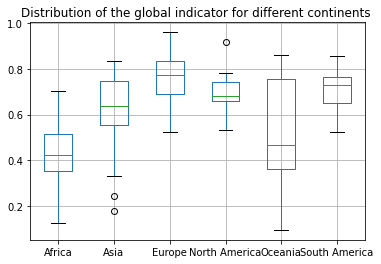

In [88]:
# On affiche les boxplot représentant la distribution de notre indicateur global par continent 
df_indicateurs2.boxplot()
plt.title("Distribution of the global indicator for different continents ")

On obtient ici la dispersion de l'indicateur en fonction des différents continents. Ainsi, l'indicateur global semble assez élevé en Europe (centré aux alentours de 0.8) et plus faible en Afrique par exemple (l'indicateur y est centré aux alentours de 0.4). La dispesion de l'indicateur est assez faible pour les pays d'Europe et d'Amérique du Nord ce qui traduit une certaine homogénéité de la situation féminine dans sur ces continents, ce qui n'est pas le cas par exemple de l'Océanie, où l'indicateur est très dispersé. 

# 7. Visualisation de l'indicateur 

Cette partie qui illustre la répartition de notre indicateur sur une carte du Monde requiert la dernière version du module geopandas. Il est possible de la faire marcher en utilisant Google Collab. 

In [89]:
!pip install folium
!pip install mapclassify
!pip install geopandas

In [90]:
import geopandas as gpd

In [91]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))#dataframe du module geopandas qui contient les inndications géographiques qui vont être nécessaires pour la construction de la carte.

In [92]:
# On regarde les codes pays manquants
world[~world['iso_a3'].isin(list(df['Country Code']))][['iso_a3', 'name']]

,iso_a3,name
2,ESH,W. Sahara
20,FLK,Falkland Is.
21,-99,Norway
23,ATF,Fr. S. Antarctic Lands
43,-99,France
159,ATA,Antarctica
160,-99,N. Cyprus
167,-99,Somaliland
174,-99,Kosovo


Il y a 5 pays dans le world dataframe avec des codes iso_a3 à "-99". Trois d'entre eux sont contestés ou n'ont pas encore de désignation ISO. La France et la Norvège ont respectivement les codes ISO "FRA" et "NOR" et sont mises à jour dans le cadre géodésique avec ce qui suit.


In [93]:
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'

On fusionne désormais les données de l'indicateur multidimensionnel des inégalités que subissent les femmes avec le cadre géodésique mondial, en créant notre carte. La fusion est effectuée avec une jointure gauche sur le code pays. Cela réduit le nombre de pays qui ont à la fois des informations sur l'indicateur et sur la géométrie. L'utilisation d'une jointure "gauche" permet de conserver tous les pays du géodatabase mondial original avec les données géométriques appropriées. 

In [94]:
world.merge(df_indicateurs, how = 'inner' ,right_on = 'Country Code', left_on = 'iso_a3').explore(
     column="Indicateur global", 
     tooltip="Indicateur global", 
     popup=True, 
     tiles="CartoDB positron", 
     cmap="OrRd", # use "Set1" matplotlib colormap
     style_kwds=dict(color="black") # use black outline
    )

# Conclusion

Nous avons construit un indicateur multimensionnel sur la condition des femmes, en nous appuyant sur plusieurs domaines mis en avant par la littérature économique: la santé, la condition des femmes au sein du ménage, l'intégrité physique, l'éducation, les ressources économiques, l'action politique et l'activité économique. 

Bien sûr notre analyse présente des défauts, notamment pour ce qui concerne la sélection des variables et la construction empirique de l'indicateur global de la condition des femmes dans un pays, qui ne prétend pas à la rigueur scientifique de certains indicateurs qui ont pu être crées pour mesurer les inégalités entre les hommes et les femmes (à l'image du GII). Notre indicateur toutefois permet de bien saisir la multidimensionnalité du problème, et l'analyse économétrique que nous avons pu effectuer met bien en évidence une relation linéaire entre la condition des femmes dans un pays et le PIB par tête de ce pays. Plus la condition des femmes dans un pays est élevée, plus le pays est développé (en termes économiques). 

Notre analyse pourrait être élargie en incorporant en plus d'une réflexion sur la dimension économique du développement des pays, une réflexion sur une dimension plus humaine, au travers d'autres indicateurs comme l'IDH (Indice de développement humain). 